In [6]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import keras
import os

import sys

import random

import segmentation_models as sm

import albumentations as A

from keras import backend as K
import tensorflow as tf


import gc
gc.collect()

11035

## final_fun_1 ##

In [2]:
# It takes images as input and generates segmented image having mask information

def final_fun_1(X):
    # helper function for data visualization
    def visualize(**images):
        """PLot images in one row."""
        n = len(images)
        plt.figure(figsize=(16, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        plt.show()
        
    # helper function for data visualization    
    def denormalize(x):
        """Scale image to range 0..1 for correct plot"""
        x_max = np.percentile(x, 98)
        x_min = np.percentile(x, 2)    
        x = (x - x_min) / (x_max - x_min)
        x = x.clip(0, 1)
        return x
    
    def get_preprocessing(preprocessing_fn):
        """Construct preprocessing transform
        
        Args:
            preprocessing_fn (callbale): data normalization function 
                (can be specific for each pretrained neural network)
        Return:
            transform: albumentations.Compose
        
        """
        
        _transform = [
            A.Lambda(image=preprocessing_fn),
        ]
        return A.Compose(_transform)
    
    # classes for data loading and preprocessing
    class Dataset:
        """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
        
        Args:
            images_dir (str): path to images folder
            masks_dir (str): path to segmentation masks folder
            class_values (list): values of classes to extract from segmentation mask
            augmentation (albumentations.Compose): data transfromation pipeline 
                (e.g. flip, scale, etc.)
            preprocessing (albumentations.Compose): data preprocessing 
                (e.g. noralization, shape manipulation, etc.)
        
        """
        
        CLASSES = {'manipulated': 0, 'non_manipulated': 255}
        
        def __init__(
                self, 
                images_dir, 
                classes=None, 
                augmentation=None, 
                preprocessing=None,
        ):
            self.ids = os.listdir(images_dir)
            self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
            
            # convert str names to class values on masks
            self.class_values = [self.CLASSES[cls] for cls in classes]

            self.preprocessing = preprocessing
        
        def __getitem__(self, i):
            
            # read data
            dim= (512,512)
            
            img = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
            image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # Downscale without Preserving Aspect Ratio
    
           
            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image)
                image = sample['image']
            
            image = np.array(image).astype(np.float32) / 255
                       
            return image
            
        def __len__(self):
            return len(self.ids)
        
        
    class Dataloder(keras.utils.Sequence):
        """Load data from dataset and form batches
        
        Args:
            dataset: instance of Dataset class for image loading and preprocessing.
            batch_size: Integet number of images in batch.
            shuffle: Boolean, if `True` shuffle image indexes each epoch.
        """
        
        def __init__(self, dataset, batch_size=1, shuffle=False):
            self.dataset = dataset
            self.batch_size = batch_size
            self.shuffle = shuffle
            self.indexes = np.arange(len(dataset))
            self.on_epoch_end()
            
            
    
        def __getitem__(self, i):
            
            # collect batch data
            start = i * self.batch_size
            stop = (i + 1) * self.batch_size
            data = []
            for j in range(start, stop):
                data.append(self.dataset[j])
            
            # transpose list of lists
            batch = [np.stack(samples, axis=0) for samples in zip(*data)]
            
            return batch
        
        def __len__(self):
            """Denotes the number of batches per epoch"""
            return len(self.indexes) // self.batch_size
        
        def on_epoch_end(self):
            """Callback function to shuffle indexes each epoch"""
            if self.shuffle:
                self.indexes = np.random.permutation(self.indexes)
                

        
    
    CLASSES = ['manipulated']
    BACKBONE = 'efficientnetb3'
    activation = 'sigmoid'
    n_classes = 1
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    
    model.load_weights('./best_model_columbia.h5')
    
    test_dataset = Dataset(
        X,
        classes=CLASSES,
        preprocessing=get_preprocessing(preprocess_input),
    )
    
    n = 2
    ids = np.random.choice(np.arange(len(test_dataset)), size=n)
    
    for i in ids:
        
        image = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image).round()
        
        visualize(
            image=denormalize(image.squeeze()),
            pr_mask=pr_mask[..., 0].squeeze(),
        )




Instructions for updating:
Colocations handled automatically by placer.


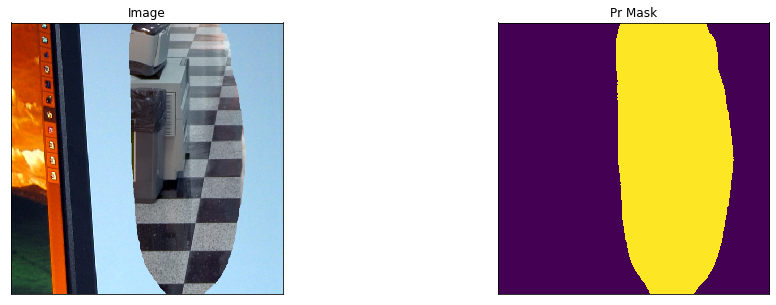

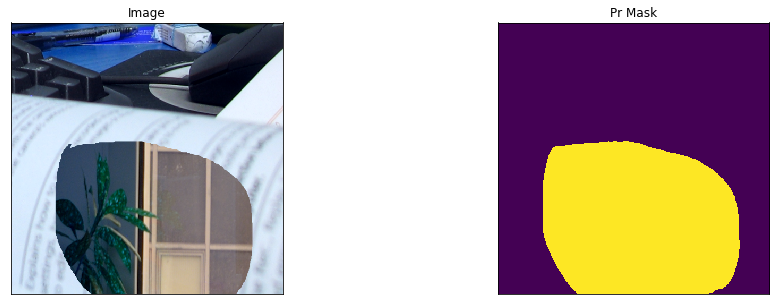

In [3]:
base_folder='G:/sourav/prog/notebook/Image_manipulation_detection-master/image-splicing-localization-master/data/'
x_test_dir=base_folder+'/columbia_img/images/test'


final_fun_1(x_test_dir)

## final_fun_2 ## 

In [4]:
# It takes original images and ground truth as input and gives evaluation metrics per image based on prediction

def final_fun_2(X,Y):
    # helper function for data visualization
    def visualize(**images):
        """PLot images in one row."""
        n = len(images)
        plt.figure(figsize=(16, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        plt.show()
        
    # helper function for data visualization    
    def denormalize(x):
        """Scale image to range 0..1 for correct plot"""
        x_max = np.percentile(x, 98)
        x_min = np.percentile(x, 2)    
        x = (x - x_min) / (x_max - x_min)
        x = x.clip(0, 1)
        return x
    
    def get_preprocessing(preprocessing_fn):
        """Construct preprocessing transform
        
        Args:
            preprocessing_fn (callbale): data normalization function 
                (can be specific for each pretrained neural network)
        Return:
            transform: albumentations.Compose
        
        """
        
        _transform = [
            A.Lambda(image=preprocessing_fn),
        ]
        return A.Compose(_transform)
    
    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return K.eval(iou)
    
    def dice_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
        return K.eval(dice)

    # classes for data loading and preprocessing
    class Dataset:
        """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
        
        Args:
            images_dir (str): path to images folder
            masks_dir (str): path to segmentation masks folder
            class_values (list): values of classes to extract from segmentation mask
            augmentation (albumentations.Compose): data transfromation pipeline 
                (e.g. flip, scale, etc.)
            preprocessing (albumentations.Compose): data preprocessing 
                (e.g. noralization, shape manipulation, etc.)
        
        """
        
        CLASSES = {'manipulated': 0, 'non_manipulated': 255}
        
        def __init__(
                self, 
                images_dir,
                masks_dir,
                classes=None, 
                augmentation=None, 
                preprocessing=None,
        ):
            self.ids = os.listdir(images_dir)
            self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
            
            # convert str names to class values on masks
            self.class_values = [self.CLASSES[cls] for cls in classes]

            self.preprocessing = preprocessing
        
        def __getitem__(self, i):
            
            # read data
            dim= (512,512)
            
            img = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
            image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # Downscale without Preserving Aspect Ratio
    
            msk = cv2.imread(self.masks_fps[i], 0)
            mask = cv2.resize(msk, dim, interpolation = cv2.INTER_AREA) # Downscale without Preserving Aspect Ratio
            masks = [(mask == self.class_values) ]
            mask = np.stack(masks, axis=-1).astype('float')
           
            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            
            image = np.array(image).astype(np.float32) / 255
                       
            return image, mask
            
        def __len__(self):
            return len(self.ids)
        
        
    class Dataloder(keras.utils.Sequence):
        """Load data from dataset and form batches
        
        Args:
            dataset: instance of Dataset class for image loading and preprocessing.
            batch_size: Integet number of images in batch.
            shuffle: Boolean, if `True` shuffle image indexes each epoch.
        """
        
        def __init__(self, dataset, batch_size=1, shuffle=False):
            self.dataset = dataset
            self.batch_size = batch_size
            self.shuffle = shuffle
            self.indexes = np.arange(len(dataset))
            self.on_epoch_end()
            
            
    
        def __getitem__(self, i):
            
            # collect batch data
            start = i * self.batch_size
            stop = (i + 1) * self.batch_size
            data = []
            for j in range(start, stop):
                data.append(self.dataset[j])
            
            # transpose list of lists
            batch = [np.stack(samples, axis=0) for samples in zip(*data)]
            
            return batch
        
        def __len__(self):
            """Denotes the number of batches per epoch"""
            return len(self.indexes) // self.batch_size
        
        def on_epoch_end(self):
            """Callback function to shuffle indexes each epoch"""
            if self.shuffle:
                self.indexes = np.random.permutation(self.indexes)
                

        
    
    CLASSES = ['manipulated']
    BACKBONE = 'efficientnetb3'
    activation = 'sigmoid'
    n_classes = 1
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    
    model.load_weights('./best_model_columbia.h5')
    
    test_dataset = Dataset(
        X,
        Y,
        classes=CLASSES,
        preprocessing=get_preprocessing(preprocess_input),
    )
    
    n = 2
    ids = np.random.choice(np.arange(len(test_dataset)), size=n)
    
    for i in ids:
        
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image).round().astype(np.float32)

        gt_mask=gt_mask[np.newaxis,:,:].astype(np.float32)

        iou=iou_coef(gt_mask,pr_mask)
        f1_score=dice_coef(gt_mask,pr_mask)
        
        print("IOU: ",iou)
        print("F1 Score: ",f1_score)

        visualize(
            image=denormalize(image.squeeze()),
            gt_mask=gt_mask[..., 0].squeeze(),
            pr_mask=pr_mask[..., 0].squeeze(),
        )




IOU:  0.94417
F1 Score:  0.9712832


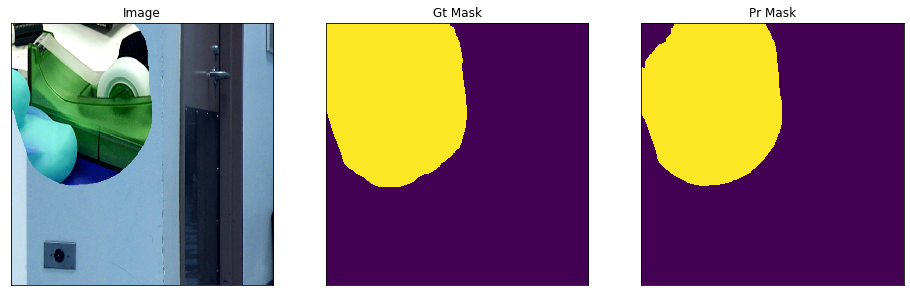

IOU:  0.990391
F1 Score:  0.9951723


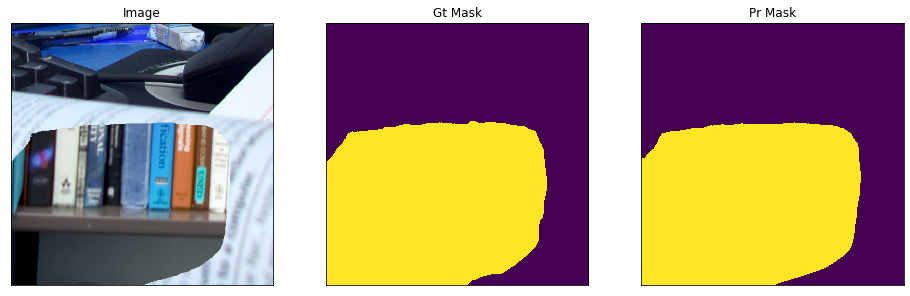

In [5]:
base_folder='G:/sourav/prog/notebook/Image_manipulation_detection-master/image-splicing-localization-master/data/'
x_test_dir=base_folder+'/columbia_img/images/test'
y_test_dir=base_folder+'/columbia_img/masks/test'

final_fun_2(x_test_dir,y_test_dir)